In [1]:
using IonSim
using QuantumOptics
using QuantumOptics: timeevolution, stochastic
import DifferentialEquations
import PyPlot
const plt = PyPlot
using Distributions
using Expectations

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [3]:
C = Ca40(["S-1/2", "D-1/2"])
L = Laser()
νa = 1.0e6  # axial trap frequency
νr = 3.0e6    # radial trap frequency
chain = LinearChain(
        ions=[C], com_frequencies=(x=νr,y=νr,z=νa), 
        vibrational_modes=(x=[], y=[], z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);
L.k = (x̂ + ẑ)/√2 
L.ϵ = (x̂ - ẑ)/√2;
mode = T.configuration.vibrational_modes.z[1]

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim C:\Users\suman\.julia\packages\IonSim\5Hvou\src\lasers.jl:84


VibrationalMode(ν=1.0e6, axis=ẑ, N=10)

# RAP on RSB transition

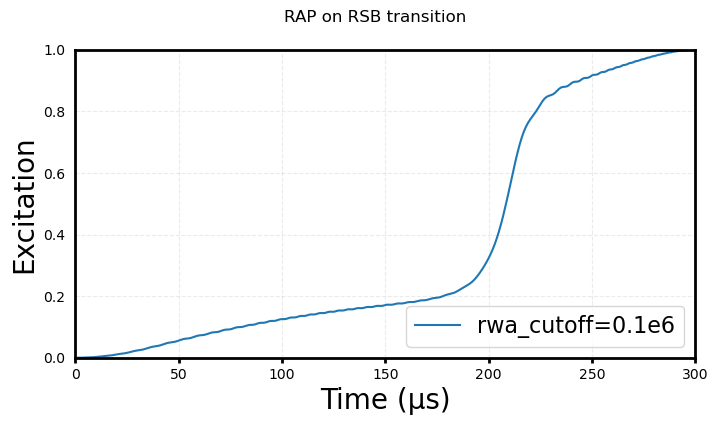

  0.716317 seconds (14.84 M allocations: 328.499 MiB, 10.33% gc time)


PyObject <matplotlib.legend.Legend object at 0x000000003FFE2760>

In [5]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

Tp = 300
mode.N = 10
ψi_mode = thermalstate(mode, 2)

ψi1 = dm(C["S-1/2"]) ⊗ dm(mode[2])
#ψi1 = dm(C["S-1/2"]) ⊗ thermalstate(mode, 5)

δν = 300e3
Δϕ = 2π * (δν/2) * 1e-6
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
    else
        return 0
    end
end
L.E = Ω;
L.Δ  = Δf - mode.ν 


tspan = 0:Tp/300:Tp
h = hamiltonian(T, rwa_cutoff=2e6)
@time tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi1, h)

# ψo = ψt[end]  
# p = expect(ionprojector(T, "D-1/2"), ψo)
# print(abs(p))

ex1 = expect(ionprojector(T, "D-1/2"), ψt)
#plt.plot(tspan, ex1)
plt.plot(tout, ex1, label="rwa_cutoff=0.1e6")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.suptitle("RAP on RSB transition")
plt.legend(loc="lower right", fontsize = 16)

In [7]:
p = expect(ionprojector(T, "D-1/2"), ψt[end])
p = real(p)
# if p > 1
#     p = 1
# elseif p < 0
#     p = 0
# end
B = Bernoulli(p)
rand(B, 1)[1]


true

# theoretical_nbar

In [26]:
# n = one(C) ⊗ thermalstate(mode, 5)
# ψi = dm(C["S-1/2"]) ⊗ dm(mode[5])
# theoretical_nbar = real(expect(n, ψi))

## scaling with fock states |n>; sequence rsb RAP pulse followed by carrier pi pulse

In [7]:
mode.N = 10
n̄ = 10
n = one(C) ⊗ IonSim.number(mode)

T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

δν = 300e3
Tp = 300
Δϕ = 2π * (δν/2) * 1e-6

# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
    else
        return 0
    end
end



number_of_repititions = 100
phonon_number_measurement = 0
theoretical_nbar = 0

for k in 1:number_of_repititions
    ψi = C["S-1/2"] ⊗ mode[n̄]
    theoretical_nbar = real(expect(n, ψi))
    i = 0
    while true
        # # simulation with RAP pulse on rsb transition

        L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
        L.E = Ω;
        L.Δ  = Δf - mode.ν 


        tspan = 0:Tp/300:Tp 
        h = hamiltonian(T, rwa_cutoff=2e6)
        tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h, displacement="analytic")

        ψo = ψt[end]

        p = expect(ionprojector(T, "D-1/2"), ψo)
        p = real(p)
        if p > 1
            p = 1
        elseif p < 0
            p = 0
        end
        B = Bernoulli(p)
        b = rand(B, 1)[1]
        if !b
            break
        else
        # simulation with pi pulse on carrier
            L.Δ = Δf
            E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
            L.E = E1
            L.ϕ = 0

            tpi = 3 # length of pi pulse|


            tlist = 0:0.01:tpi
            h = hamiltonian(T, rwa_cutoff=2e6)
            tout, ψt = timeevolution.schroedinger_dynamic(tlist, ψo, h, displacement="analytic")

            ψi = ψt[end]
            i += 1
        end
    end
    phonon_number_measurement += i
    println(phonon_number_measurement)
end

average_phonon_number_measurement = phonon_number_measurement / number_of_repititions
error = abs(theoretical_nbar - average_phonon_number_measurement) / theoretical_nbar;
println("average: ", average_phonon_number_measurement);
println("theoretical_nbar: ", theoretical_nbar);
println("error: ", error);

10
20
30
40
50
59
69
79
87
97
107
117
127
137
147
157
167
177
187
197
207
217
227
237
247
257
265
275
285
295
305
315
325
335
345
355
365
375
385
395
405
415
425
435
445
455
466
476
486
496
506
516
526
536
546
556
566
576
586
596
606
616
624
634
639
649
652
662
672
682
692
702
712
722
732
742
752
762
772
782
792
803
813
823
833
843
853
863
873
883
893
903
913
923
933
943
952
962
972
982
average: 9.82
theoretical_nbar: 10.0
error: 0.01799999999999997


In [ ]:
# n̄ = 5
# n = one(C) ⊗ IonSim.number(mode)
# ψi = C["S-1/2"] ⊗ mode[n̄]
# theoretical_nbar = real(expect(n, ψi))
# print(theoretical_nbar)

# Error scaling with theoretical n̄

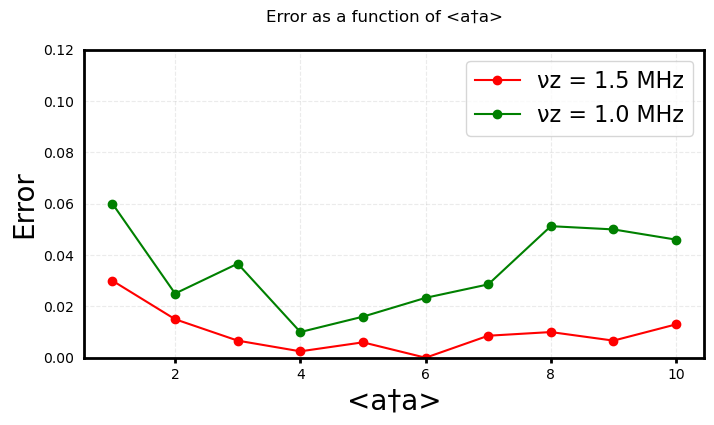

PyObject Text(0.5, 0.98, 'Error as a function of <a†a>')

In [9]:
# rwa_cutoff = 2e6
# number_of_repititions = 100
# Tp = 150
# axial_trap_freq = 1.5e6
# n̄ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# theoretical_nbar = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# average_phonon_number_measurement = [9.91, 8.89, 7.87, 6.93, 5.87, 4.86, 3.87, 2.81, 1.89, 0.89]
# error = [0.00899, 0.01222, 0.01625, 0.01, 0.02166, 0.02799, 0.03249, 0.06333, 0.05500, 0.10999]

rwa_cutoff = 2e6
number_of_repititions = 100
Tp = 300
axial_trap_freq = 1.5e6
n̄ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
theoretical_nbar = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
average_phonon_number_measurement = [9.87, 8.94, 7.92, 6.94, 6, 4.97, 3.99, 2.98, 1.97, 0.97]
error = [0.013, 0.00666, 0.01, 0.00857, 0, 0.006, 0.00249, 0.00666, 0.015, 0.03]


# rwa_cutoff = 1.5e6
# number_of_repititions = 100
# Tp = 300
# axial_trap_freq = 1e6
# n̄ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
theoretical_nbar_1 = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# average_phonon_number_measurement = [9.54, 8.55, 7.59, 6.8, 5.86, 4.92, 3.96, 2.89, 1.95, 0.94]
error_1 = [0.046, 0.04999, 0.05125, 0.02857, 0.02333, 0.016, 0.01, 0.03666, 0.025, 0.06]

plt.plot(theoretical_nbar, error, "ro-", label="νz = 1.5 MHz")
plt.plot(theoretical_nbar_1, error_1, "go-", label="νz = 1.0 MHz")
plt.legend(loc="upper right", fontsize = 16)
plt.ylim(0, 0.12)
plt.ylabel("Error")
plt.xlabel("<a†a>");
plt.suptitle("Error as a function of <a†a>")

### sequence of simulation; pi pulse on carrier followed by bsb RAP pulse

  0.034385 seconds (6.93 k allocations: 581.875 KiB)


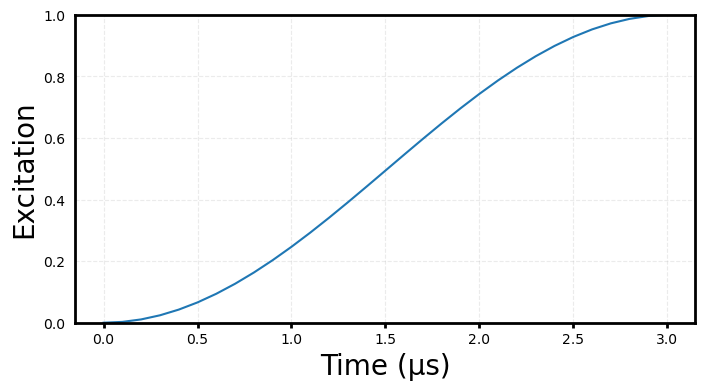

  4.144261 seconds (1.33 M allocations: 67.183 MiB, 84.07% gc time)


In [35]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L.Δ = Δf
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
L.E = E1
L.ϕ = 0

ψi1 = dm(C["S-1/2"]) ⊗ dm(mode[2])

tpi = 3 # length of pi pulse


tlist = 0:0.1:tpi
h = hamiltonian(T, rwa_cutoff=1e5)
@time tout, ψt = timeevolution.schroedinger_dynamic(tlist, ψi1, h)

ψi2 = ψt[end]
δν = 300e3
Δϕ = 2π * (δν/2) * 1e-6
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
    else
        return 0
    end
end
L.E = Ω;
L.Δ  = Δf + mode.ν

Tp = 500
tspan = 0:0.1:Tp
h = hamiltonian(T, rwa_cutoff=1e5)
@time tout, ψt1 = timeevolution.schroedinger_dynamic(tspan, ψi2, h)

# ψi3 = ψt1[end]
# tlist = 0:0.1:tpi
# h = hamiltonian(T, rwa_cutoff=1e5)
# @time tout, ψt2 = timeevolution.schroedinger_dynamic(tlist, ψi3, h)

# ψi4 = ψt2[end]
# δν = 300e3
# Δϕ = 2π * (δν/2) * 1e-6
# L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
# # amplitude Rabi_freq
# function Ω(t)
#     if t < Tp
#         return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
#     else
#         return 0
#     end
# end
# L.E = Ω;
# L.Δ  = Δf + mode.ν

# Tp = 300
# tspan = 0:0.1:Tp
# h = hamiltonian(T, rwa_cutoff=1e5)
# @time tout, ψt3 = timeevolution.schroedinger_dynamic(tspan, ψi4, h)

ex1 = expect(ionprojector(T, "D-1/2"), ψt)
#plt.plot(tout, ex1)
plt.plot(tlist, ex1)
#plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

In [30]:
η = abs(get_η(mode, L, C))

0.07105425653011588